Utility plotting functions and node labels

In [1]:
import sys
sys.path.append('..')
from typing import Optional
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.ndimage import convolve
from plotting.plot_circular_graph import plot_circular_graph
from plotting_styles import colors
import eval_reallabor_utils

import data_utils
sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS
from feature_names import CONSTRUCTS_ANY_NON_CONDITIONAL as CONSTRUCTS
CONSTRUCTS = [c.lower() for c in CONSTRUCTS]
from feature_names import FLIP_OBSERVATION
NEGATIVE_ITEMS = [i for i in range(len(LABELS)) if LABELS[i] in FLIP_OBSERVATION]
PRINT_LABELS = [l.removeprefix('EMA_') for l in LABELS]

def plot_network_graph(networks: tc.Tensor, directed: bool=True, invert_negative: bool=False, hide_self_connections: bool=True,
                       alpha_level: float=0.01, fisher_transform: bool=False, edge_threshold: Optional[float]=None,
                       node_labels: Optional[list]=None, title: Optional[str]=None, ax: Optional[plt.Axes]=None):    

    if fisher_transform:
        networks = tc.arctanh(networks)
    sig_adj = stats.ttest_1samp(networks, 0, axis=0).pvalue   # Show only connections with a weight significantly different from 0
    if fisher_transform:
        networks = tc.tanh(networks)
    networks = tc.nanmean(networks, dim=0)
    if fisher_transform:
        networks = tc.tanh(networks)
    if hide_self_connections:
        for i in range(networks.shape[0]):
            networks[i,i] = 0
    max_abs = networks.abs().max()
    if invert_negative:
        networks[NEGATIVE_ITEMS, :] *= -1
        networks[:, NEGATIVE_ITEMS] *= -1
        if node_labels is not None:
            node_labels = [node_labels[i] + '*' if i in NEGATIVE_ITEMS else node_labels[i] for i in range(len(node_labels)) ]

    networks_pos = networks * (networks > 0) * (sig_adj < alpha_level)
    networks_neg = networks * (networks < 0) * (sig_adj < alpha_level)
    max_pos = networks_pos.abs().max()
    max_neg = networks_neg.abs().max()

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6.27, 6.27))
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    node_color = colors.item_color_codes(LABELS) if networks.shape[0]==len(LABELS) else None
    plot_circular_graph(networks_pos, directed=directed, labels=node_labels, ax=ax, max_edge_width=max_pos/max_abs * 3, labelpad=5,
                            edge_kwargs={'edge_color':'k'}, node_kwargs={'node_color':node_color})
    plot_circular_graph(-networks_neg, directed=directed, labels=node_labels, ax=ax, max_edge_width=max_neg/max_abs * 3, labelpad=5,
                            edge_kwargs={'edge_color':'red'}, node_kwargs={'node_color':node_color})
    ax.set(xlim=(-2,2), ylim=(-2,2))
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()
    return ax, sig_adj


def plot_out_degree_centrality(networks: tc.Tensor, significant_only: bool=True, alpha_level: float=0.05,
                               node_labels: Optional[list]=None, ax: Optional[plt.Axes]=None):

    if significant_only:
        sig_adj = stats.ttest_1samp(networks, 0, axis=0).pvalue
        networks = networks * (sig_adj < alpha_level)
    out_degree_centrality = eval_reallabor_utils.weighted_degree_centrality(networks, mode='out', absolute=True)
    mean_centrality = tc.nanmean(out_degree_centrality, dim=0)
    sem_centrality = tc.nanmean((out_degree_centrality - mean_centrality)**2, dim=0) / np.sqrt(out_degree_centrality.shape[0])
    order = tc.argsort(mean_centrality, descending=True)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6.27, 2.5))
    ax.bar(range(len(mean_centrality)), mean_centrality[order], yerr=sem_centrality[order], color=colors.item_color_codes(np.array(LABELS)[order]))
    ax.set_ylabel('out-degree centrality')
    if node_labels is not None:
        node_labels = np.array(node_labels)
        ax.set_xticks(range(len(mean_centrality)), labels=node_labels[order], rotation=45, ha='right')
    return ax


def rolling_2d_nanmean(df: pd.DataFrame, window: int):
    kernel = np.ones((window, window), dtype=float)
    values = df.values
    # Replace NaNs with 0 for summing
    value_sum = convolve(np.nan_to_num(values, nan=0.0), kernel, mode='constant', cval=0.0)
    # Count non-NaNs in each window
    count = convolve(~np.isnan(values)*1, kernel, mode='constant', cval=0.0)
    # Compute the mean, avoiding division by zero
    with np.errstate(invalid='ignore', divide='ignore'):
        result = value_sum / count
    return pd.DataFrame(result, index=df.index, columns=df.columns), pd.DataFrame(count, index=df.index, columns=df.columns)

In [21]:
distance_metrics = ['cosine']
dm_bounds = [(0,2)]

PLRNN networks

In [ ]:
import sys
sys.path.append('..')
from tqdm import tqdm
import torch as tc
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2, 3]
combined_eval_file = []
all_dist_kalman = {dm: {mrt: {} for mrt in MRT} for dm in distance_metrics}

with PaperStyle(settings={'axes.grid':False, 'axes.facecolor':'white'}):

    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_every_day_x6')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')

        models = eval_reallabor_utils.ModelCatalogue(results_dir)
        data_files = data_utils.get_data_files(test_data_dir)
        participants = data_utils.get_participant_ids(data_files)
        dist = {}
        for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Getting networks of MRT {mrt}'):
            participant_networks = {}
            for model_dir in models.get_best_model_dirs(p):
                args = utils.load_args(model_dir)
                model = PLRNN()
                model.init_from_model_path(model_dir)
                x = tc.tensor(df[LABELS].to_numpy()).float()
                network = eval_reallabor_utils.get_network_matrix(model, x).nanmean(0)
                participant_networks[int(float(args['train_on_data_until_timestep']))] = network.flatten()
            participant_networks = pd.DataFrame(participant_networks)
            for dm in distance_metrics:
                all_dist_plrnn[dm][mrt][p] = pd.DataFrame(sklearn.metrics.pairwise_distances(participant_networks.T, metric=dm),
                                                index=participant_networks.columns, columns=participant_networks.columns)

Getting networks of MRT 3: 100%|██████████| 59/59 [00:41<00:00,  1.42it/s]


In [36]:
dist_plrnn_longest_timeseries = {dm: {mrt: {} for mrt in MRT} for dm in distance_metrics}

fact_sheet = []

for mrt in MRT:
    for p in all_dist_plrnn[distance_metrics[0]][mrt].keys():
        max_len = all_dist_plrnn[distance_metrics[0]][mrt][p].index.max()
        num_models = all_dist_plrnn[distance_metrics[0]][mrt][p].shape[0]
        fact_sheet.append({
            'participant': p,
            'mrt': mrt,
            'max_length': max_len,
            'num_models': num_models
        })
        if max_len > 234:
            for dm in distance_metrics:
                dist_plrnn_longest_timeseries[dm][mrt][p] = all_dist_plrnn[dm][mrt][p].copy()
                dist_plrnn_longest_timeseries[dm][mrt][p].index = dist_plrnn_longest_timeseries[dm][mrt][p].index / dist_plrnn_longest_timeseries[dm][mrt][p].index.max() * 100
                dist_plrnn_longest_timeseries[dm][mrt][p].columns = dist_plrnn_longest_timeseries[dm][mrt][p].columns / dist_plrnn_longest_timeseries[dm][mrt][p].columns.max() * 100
        
fact_sheet = pd.DataFrame(fact_sheet).set_index('participant')
fact_sheet.max_length.median()

np.float64(234.0)

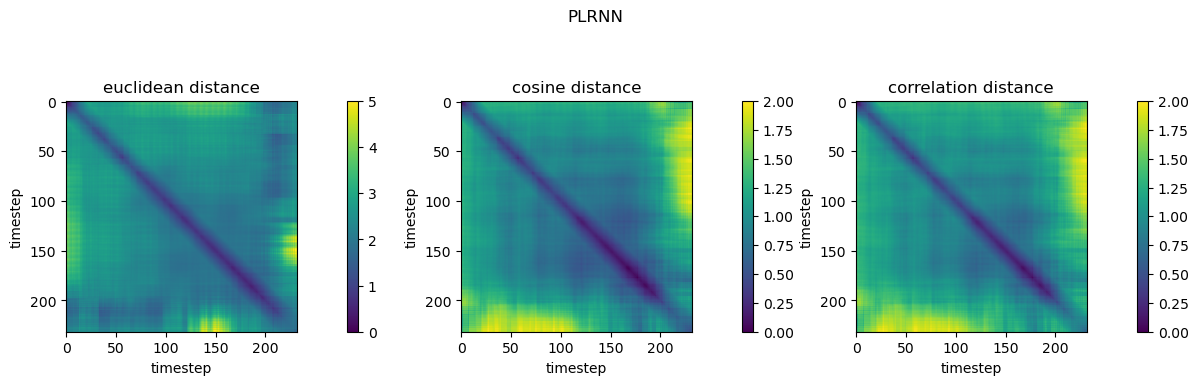

In [5]:
from plotting_utils import heatmap_with_colorbar

fig, axes = plt.subplots((len(distance_metrics)+1)//3, 3, figsize=(12, 3*(len(distance_metrics)+1)//3))
# fig, axes = subplots_with_colorbar()
axes = axes.flatten()
for i, dm in enumerate(distance_metrics):
    mean_dist, count = rolling_2d_nanmean(pd.concat({
                                                     **all_dist_plrnn[dm][2], 
                                                     **all_dist_plrnn[dm][3]
                                                    }, 
                                                     axis=0).droplevel(0).sort_index().sort_index(axis=1).groupby(level=0).mean(), 20)
    heatmap_with_colorbar(axes[i], mean_dist, vmin=dm_bounds[i][0], vmax=dm_bounds[i][1])
    # axes[i].imshow(np.zeros_like(mean_dist_plrnn.to_numpy()), cmap='binary', vmin=0, vmax=1)
    axes[i].imshow(mean_dist)#, alpha=count/count.to_numpy().max())
    axes[i].set_xlabel('timestep')
    axes[i].set_ylabel('timestep')
    axes[i].set_title(f'{dm} distance')
plt.suptitle('PLRNN')
plt.tight_layout()

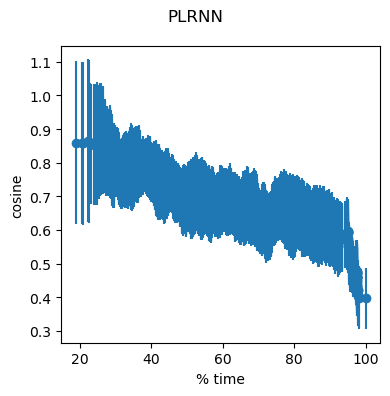

In [37]:
fig, axes = plt.subplots(1, len(distance_metrics), figsize=(4, len(distance_metrics)*3+1), squeeze=False)
# fig, axes = subplots_with_colorbar()
axes = axes.flatten()
for i, dm in enumerate(distance_metrics):
    mean_dist, count = rolling_2d_nanmean(pd.concat({
                                                     **dist_plrnn_longest_timeseries[dm][2], 
                                                     **dist_plrnn_longest_timeseries[dm][3]
                                                    }, 
                                                     axis=0).droplevel(0).sort_index().sort_index(axis=1).groupby(level=0).mean(), 50)
    se_dist, count = rolling_2d_nanmean(pd.concat({
                                                     **dist_plrnn_longest_timeseries[dm][2], 
                                                     **dist_plrnn_longest_timeseries[dm][3]
                                                    }, 
                                                     axis=0).droplevel(0).sort_index().sort_index(axis=1).groupby(level=0).sem(), 50)
    axes[i].errorbar(mean_dist.columns, mean_dist.loc[100], yerr=se_dist.loc[100], fmt='-o', label=f'{dm}')
    axes[i].set_xlabel(r'% time')
    axes[i].set_ylabel(dm)
plt.suptitle('PLRNN')
plt.tight_layout()

KalmanFilter networks

In [22]:
import sys
sys.path.append('..')
from tqdm import tqdm
import torch as tc
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from comparison_models.simple_models.models import KalmanFilter

MRT = [2, 3]
combined_eval_file = []
all_dist_kalman = {dm: {mrt: {} for mrt in MRT} for dm in distance_metrics}

with PaperStyle(settings={'axes.grid':False, 'axes.facecolor':'white'}):

    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_Kalman_every_day')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')

        models = eval_reallabor_utils.ModelCatalogue(results_dir)
        data_files = data_utils.get_data_files(test_data_dir)
        participants = data_utils.get_participant_ids(data_files)
        dist = {}
        for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Getting networks of MRT {mrt}'):
            participant_networks = {}
            if p not in models.catalogue.participant:
                continue
            for model_dir in models.get_best_model_dirs(p):
                args = utils.load_args(model_dir)
                model = KalmanFilter(args)
                model.init_from_model_path(model_dir)
                x = tc.tensor(df[LABELS].to_numpy()).float()
                network = eval_reallabor_utils.get_network_matrix(model, x).nanmean(0)
                participant_networks[int(float(args['train_on_data_until_timestep']))] = network.flatten()
            participant_networks = pd.DataFrame(participant_networks)
            failed_metrics = []
            for dm in distance_metrics:
                try:
                    all_dist_kalman[dm][mrt][p] = pd.DataFrame(sklearn.metrics.pairwise_distances(participant_networks.T, metric=dm),
                                                    index=participant_networks.columns, columns=participant_networks.columns)   
                except:
                    failed_metrics.append(dm)
            if len(failed_metrics) > 0:
                print(f'{failed_metrics} could not be calculated for participant {p}') 

Getting networks of MRT 2:   2%|▏         | 1/56 [00:00<00:50,  1.09it/s]

['cosine'] could not be calculated for participant 13


Getting networks of MRT 2:  34%|███▍      | 19/56 [00:10<00:22,  1.65it/s]

['cosine'] could not be calculated for participant 40


Getting networks of MRT 3:  47%|████▋     | 28/59 [00:19<00:21,  1.42it/s]

['cosine'] could not be calculated for participant 236


Getting networks of MRT 3:  54%|█████▍    | 32/59 [00:22<00:21,  1.28it/s]

['cosine'] could not be calculated for participant 241


Getting networks of MRT 3:  64%|██████▍   | 38/59 [00:25<00:14,  1.47it/s]

['cosine'] could not be calculated for participant 249


Getting networks of MRT 3:  71%|███████   | 42/59 [00:27<00:10,  1.65it/s]

['cosine'] could not be calculated for participant 256


Getting networks of MRT 3:  75%|███████▍  | 44/59 [00:28<00:07,  2.02it/s]

['cosine'] could not be calculated for participant 258


Getting networks of MRT 3:  88%|████████▊ | 52/59 [00:32<00:03,  1.99it/s]

['cosine'] could not be calculated for participant 266


Getting networks of MRT 3: 100%|██████████| 59/59 [00:38<00:00,  1.53it/s]


In [41]:
dist_kalman_longest_timeseries = {dm: {mrt: {} for mrt in MRT} for dm in distance_metrics}

fact_sheet = []

for mrt in MRT:
    for p in all_dist_kalman[distance_metrics[0]][mrt].keys():
        max_len = all_dist_kalman[distance_metrics[0]][mrt][p].index.max()
        num_models = all_dist_kalman[distance_metrics[0]][mrt][p].shape[0]
        fact_sheet.append({
            'participant': p,
            'mrt': mrt,
            'max_length': max_len,
            'num_models': num_models
        })
        if max_len > 234:
            for dm in distance_metrics:
                dist_kalman_longest_timeseries[dm][mrt][p] = all_dist_kalman[dm][mrt][p].copy()
                dist_kalman_longest_timeseries[dm][mrt][p].index = dist_kalman_longest_timeseries[dm][mrt][p].index / dist_kalman_longest_timeseries[dm][mrt][p].index.max() * 100
                dist_kalman_longest_timeseries[dm][mrt][p].columns = dist_kalman_longest_timeseries[dm][mrt][p].columns / dist_kalman_longest_timeseries[dm][mrt][p].columns.max() * 100
        
fact_sheet = pd.DataFrame(fact_sheet).set_index('participant')
fact_sheet.max_length.median()

np.float64(234.0)

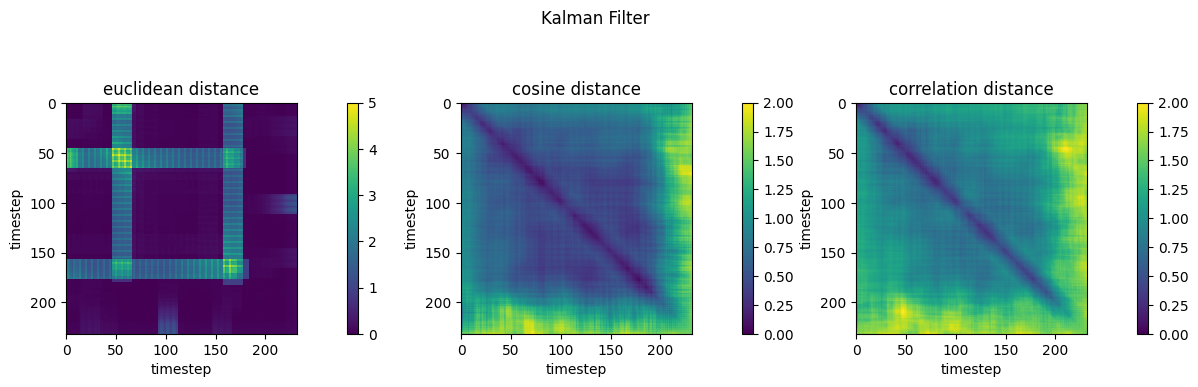

In [57]:
from plotting_utils import heatmap_with_colorbar

fig, axes = plt.subplots((len(distance_metrics)+1)//3, 3, figsize=(12, 3*(len(distance_metrics)+1)//3))
# fig, axes = subplots_with_colorbar()
axes = axes.flatten()
for i, dm in enumerate(distance_metrics):
    mean_dist, count = rolling_2d_nanmean(pd.concat({
                                                     **all_dist_kalman[dm][2], 
                                                     **all_dist_kalman[dm][3]
                                                    }, 
                                                     axis=0).droplevel(0).sort_index().sort_index(axis=1).groupby(level=0).mean(), 20)
    heatmap_with_colorbar(axes[i], mean_dist, vmin=dm_bounds[i][0], vmax=dm_bounds[i][1])
    # axes[i].imshow(np.zeros_like(mean_dist_plrnn.to_numpy()), cmap='binary', vmin=0, vmax=1)
    axes[i].imshow(mean_dist)#, alpha=count/count.to_numpy().max())
    axes[i].set_xlabel('timestep')
    axes[i].set_ylabel('timestep')
    axes[i].set_title(f'{dm} distance')
plt.suptitle('Kalman Filter')
plt.tight_layout()

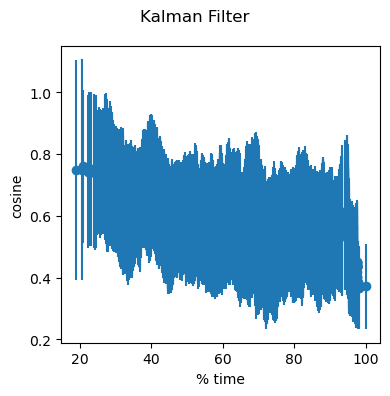

In [42]:
fig, axes = plt.subplots(1, len(distance_metrics), figsize=(4*len(distance_metrics), 4), squeeze=False)
# fig, axes = subplots_with_colorbar()
axes = axes.flatten()
for i, dm in enumerate(distance_metrics):
    mean_dist, count = rolling_2d_nanmean(pd.concat({
                                                     **dist_kalman_longest_timeseries[dm][2], 
                                                     **dist_kalman_longest_timeseries[dm][3]
                                                    }, 
                                                     axis=0).droplevel(0).sort_index().sort_index(axis=1).groupby(level=0).mean(), 50)
    se_dist, count = rolling_2d_nanmean(pd.concat({
                                                     **dist_kalman_longest_timeseries[dm][2], 
                                                     **dist_kalman_longest_timeseries[dm][3]
                                                    }, 
                                                     axis=0).droplevel(0).sort_index().sort_index(axis=1).groupby(level=0).sem(), 50)
    axes[i].errorbar(mean_dist.columns, mean_dist.loc[100], yerr=se_dist.loc[100], fmt='-o', label=f'{dm}')
    axes[i].set_xlabel(r'% time')
    axes[i].set_ylabel(dm)
plt.suptitle('Kalman Filter')
plt.tight_layout()

Networks of VAR models

In [43]:
import sys
sys.path.append('..')
from tqdm import tqdm
import torch as tc
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from comparison_models.simple_models.models import VAR1

MRT = [2, 3]
combined_eval_file = []
all_dist_var = {dm: {mrt: {} for mrt in MRT} for dm in distance_metrics}

with PaperStyle(settings={'axes.grid':False, 'axes.facecolor':'white'}):

    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_SimpleModels_every_day')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')

        models = eval_reallabor_utils.ModelCatalogue(results_dir, latent_model='VAR1')
        data_files = data_utils.get_data_files(test_data_dir)
        participants = data_utils.get_participant_ids(data_files)
        dist = {}
        for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Getting networks of MRT {mrt}'):
            participant_networks = {}
            for model_dir in models.get_best_model_dirs(p):
                args = utils.load_args(model_dir)
                model = VAR1(args)
                model.init_from_model_path(model_dir)
                x = tc.tensor(df[LABELS].to_numpy()).float()
                network = eval_reallabor_utils.get_network_matrix(model, x)
                participant_networks[int(float(args['train_on_data_until_timestep']))] = network.flatten()
            participant_networks = pd.DataFrame(participant_networks)
            failed_metrics = []
            for dm in distance_metrics:
                try:
                    all_dist_var[dm][mrt][p] = pd.DataFrame(sklearn.metrics.pairwise_distances(participant_networks.T, metric=dm),
                                                    index=participant_networks.columns, columns=participant_networks.columns)   
                except:
                    failed_metrics.append(dm)
            if len(failed_metrics) > 0:
                print(f'{failed_metrics} could not be calculated for participant {p}') 

Getting networks of MRT 3: 100%|██████████| 59/59 [00:09<00:00,  6.48it/s]


In [44]:
dist_var_longest_timeseries = {dm: {mrt: {} for mrt in MRT} for dm in distance_metrics}

fact_sheet = []

for mrt in MRT:
    for p in all_dist_var[distance_metrics[0]][mrt].keys():
        max_len = all_dist_var[distance_metrics[0]][mrt][p].index.max()
        num_models = all_dist_var[distance_metrics[0]][mrt][p].shape[0]
        fact_sheet.append({
            'participant': p,
            'mrt': mrt,
            'max_length': max_len,
            'num_models': num_models
        })
        if max_len > 234:
            for dm in distance_metrics:
                dist_var_longest_timeseries[dm][mrt][p] = all_dist_var[dm][mrt][p].copy()
                dist_var_longest_timeseries[dm][mrt][p].index = dist_var_longest_timeseries[dm][mrt][p].index / dist_var_longest_timeseries[dm][mrt][p].index.max() * 100
                dist_var_longest_timeseries[dm][mrt][p].columns = dist_var_longest_timeseries[dm][mrt][p].columns / dist_var_longest_timeseries[dm][mrt][p].columns.max() * 100
        
fact_sheet = pd.DataFrame(fact_sheet).set_index('participant')
fact_sheet.max_length.median()

np.float64(234.0)

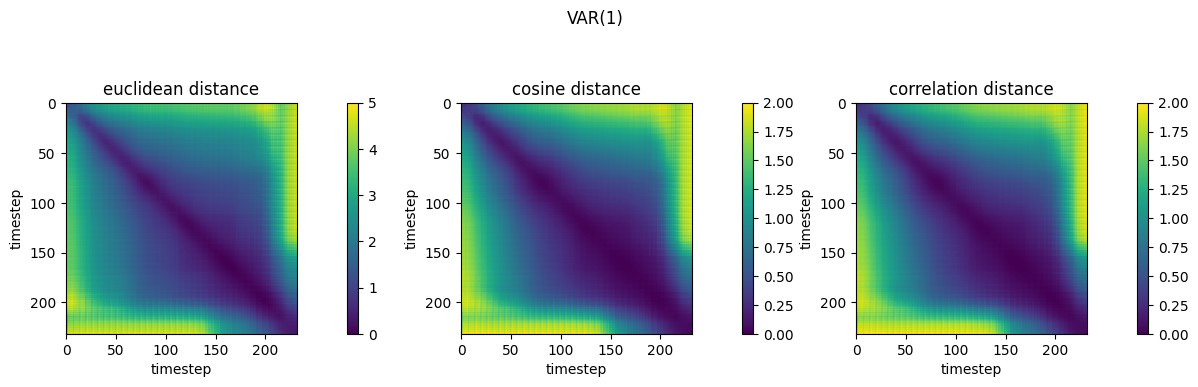

In [59]:
from plotting_utils import heatmap_with_colorbar

fig, axes = plt.subplots((len(distance_metrics)+1)//3, 3, figsize=(12, 3*(len(distance_metrics)+1)//3))
# fig, axes = subplots_with_colorbar()
axes = axes.flatten()
for i, dm in enumerate(distance_metrics):
    mean_dist, count = rolling_2d_nanmean(pd.concat({
                                                     **all_dist_var[dm][2], 
                                                     **all_dist_var[dm][3]
                                                    }, 
                                                     axis=0).droplevel(0).sort_index().sort_index(axis=1).groupby(level=0).mean(), 20)
    heatmap_with_colorbar(axes[i], mean_dist, vmin=dm_bounds[i][0], vmax=dm_bounds[i][1])
    # axes[i].imshow(np.zeros_like(mean_dist_plrnn.to_numpy()), cmap='binary', vmin=0, vmax=1)
    axes[i].imshow(mean_dist)#, alpha=count/count.to_numpy().max())
    axes[i].set_xlabel('timestep')
    axes[i].set_ylabel('timestep')
    axes[i].set_title(f'{dm} distance')
plt.suptitle('VAR(1)')
plt.tight_layout()

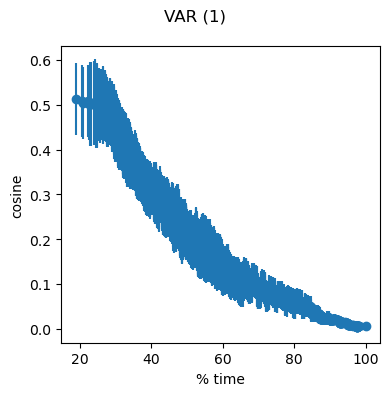

In [45]:
fig, axes = plt.subplots(1, len(distance_metrics), figsize=(4*len(distance_metrics), 4), squeeze=False)
# fig, axes = subplots_with_colorbar()
axes = axes.flatten()
for i, dm in enumerate(distance_metrics):
    mean_dist, count = rolling_2d_nanmean(pd.concat({
                                                     **dist_var_longest_timeseries[dm][2], 
                                                     **dist_var_longest_timeseries[dm][3]
                                                    }, 
                                                     axis=0).droplevel(0).sort_index().sort_index(axis=1).groupby(level=0).mean(), 50)
    se_dist, count = rolling_2d_nanmean(pd.concat({
                                                     **dist_var_longest_timeseries[dm][2], 
                                                     **dist_var_longest_timeseries[dm][3]
                                                    }, 
                                                     axis=0).droplevel(0).sort_index().sort_index(axis=1).groupby(level=0).sem(), 50)
    axes[i].errorbar(mean_dist.columns, mean_dist.loc[100], yerr=se_dist.loc[100], fmt='-o', label=f'{dm}')
    axes[i].set_xlabel(r'% time')
    axes[i].set_ylabel(dm)
plt.suptitle('VAR (1)')
plt.tight_layout()